# **Dynamic Breakpoints:**

Let's see how dynamic breakpoints work in a graph, where interruptions (breakpoints) are introduced based on conditions inside nodes.

In [7]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

## **Defining State:**

In [8]:
from typing_extensions import TypedDict

class State(TypedDict):
    input: str

## **Define Nodes:**

In [9]:
from langgraph.errors import NodeInterrupt

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")

    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

**step_2:** The second node, where a dynamic interruption (NodeInterrupt) is implemented.

* **Conditional Check:** Checks if the length of state['input'] is greater than 5.
* **Raise NodeInterrupt:** If the input is longer than 5 characters, it raises a NodeInterrupt with a message describing the issue, pausing graph execution here.

## **Building the Graph:**

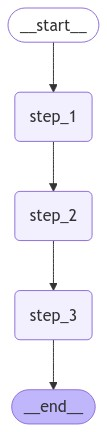

In [10]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## **Running the Graph with Initial Input:**

Let's run the graph with an input that's longer than 5 characters.

In [11]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


* **Setting Initial Input:** initial_input is set to "hello world", which has more than 5 characters, triggering the interrupt.

* **Thread Configuration:** Assigns a unique thread_id for tracking this run.

* **Running the Graph:** Starts executing the graph in values mode, which streams the full state after each node.

* **Expected Interruption:** The graph will reach step_2, detect the long input, and trigger NodeInterrupt, pausing execution here.

## **Inspecting the Graph State and the Interruption:**

In [12]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


## **Logging the Interruption:**

In [13]:
print(state.tasks)

(PregelTask(id='38f29f22-f9a1-cb15-5fda-484df775a0dc', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', when='during'),), state=None, result=None),)


**Inspecting Tasks:** Checks the graph’s tasks, where the interruption (from NodeInterrupt) should be logged.

## **Attempting to Resume the Graph Without Modifying State:**



We can try to resume the graph from the breakpoint.

But, this just re-runs the same node!

Unless state is changed we will be stuck here.

In [14]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

state = graph.get_state(thread_config)
print(state.next)

{'input': 'hello world'}
('step_2',)


* **Resuming Execution:** Tries to continue the graph by passing None, indicating that it should pick up from the last checkpoint.

* **Expected Behavior:** Because the state has not changed, the NodeInterrupt condition (input length > 5) will re-trigger, causing the graph to stop at step_2 again.

* **Re-checking State:** Confirms that step_2 is still the next node.

## **Updating State to Resolve the Interruption Condition:**

In [16]:
graph.update_state(thread_config,{"input": "hi"},)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef95b6c-2c41-62f9-8002-99e1982a171a'}}

* **Updating State:** Modifies the input key in the state to "hi", which has fewer than 5 characters, thereby bypassing the NodeInterrupt condition in step_2.

* **Using update_state:** Allows a direct state modification, simulating user input or external adjustments.

## **Resuming Graph Execution After Updating State:**

In [17]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


* **Final Run:** Resumes the graph with the updated state. Since the input length is now below 5 characters, step_2 completes successfully, allowing the graph to proceed to step_3 and then END.

* **Output:** Displays events as the graph completes its remaining steps.

## **Key Concepts:**

**Dynamic Breakpoints:** The NodeInterrupt allows the graph to pause based on conditions within nodes, adding flexibility beyond static breakpoints.

**Conditional Interruptions:** The dynamic interruption in step_2 illustrates a flexible control flow, where execution depends on input conditions.

**State Modification:** By updating the graph state (changing input to "hi"), we can bypass interruptions and continue execution.

**Memory Checkpointing:** MemorySaver maintains the graph state, allowing resumption after each interruption.